## Read data batch with sscIO, apply corrections (empty, flatfield, mask) and restore data

In [3]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import fixed
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm
from sscCdi import jupyter
from sscCdi.caterete.ptycho_restauration import restauration_processing_binning
import json
import os
import h5py
from sscIO import io
from sscPimega import pi540D

def Geometry(L):
    project = pi540D.get_detector_dictionary( L, {'geo':'nonplanar','opt':True,'mode':'virtual'} ) 
    geo = pi540D.geometry540D( project )
    return geo

def restoration_via_interface(data_path,inputs,apply_flat=True,apply_empty=True,apply_mask=True, save_data=True):
    
    metadata = json.load(open(os.path.join(data_path.rsplit('/',2)[0],'mdata.json')))
    empty_path = os.path.join(data_path.rsplit('/',2)[0],'images','empty.hdf5')
    flat_path = os.path.join(data_path.rsplit('/',2)[0],'images','flat.hdf5')
    mask_path = os.path.join(data_path.rsplit('/',2)[0],'images','mask.hdf5')    
    distance = float(metadata['/entry/beamline/experiment']["distance"])

    """ Get detector geometry from distance """
    geometry = Geometry(distance)
    
    n_of_threads, centerx, centery = inputs

    L = 3072 # PIMEGA540D size
    half_square_side = min(min(centerx,L-centerx),min(centery,L-centery)) # get the biggest size possible such that the restored difpad is still squared

    os.system(f"h5clear -s {data_path}") # gambiarra because file is not closed at the backend!
    os.system(f"h5clear -s {empty_path}") # gambiarra because file is not closed at the backend!

    print("Reading raw data from: ",data_path)
    raw_difpads,_ = io.read_volume(data_path, 'numpy', use_MPI=True, nprocs=n_of_threads)
    print("\tRaw data shape: ", raw_difpads.shape)
    print(np.max(raw_difpads),np.min(raw_difpads))

    
    """ SIMPLE RESTORATION PRIOR TO CENTER SELECTION. USED TO FIND CENTER """
    restored_full_DP = Restaurate(raw_difpads[0,:,:].astype(np.float32), geometry) # restaurate
    
    
    """ How the corrections are made prior to restoration:
    
        img[empty > 1] = -1 # Apply empty 
        img = img * np.squeeze(flat) # Apply flatfield
        img[np.abs(mask) ==1] = -1   # Apply Mask
        img = img[cy - hsize:cy + hsize, cx - hsize:cx + hsize] # Center data

    """
    if apply_empty:
        empty = np.asarray(h5py.File(empty_path, 'r')['/entry/data/data']).squeeze().astype(np.float32)
    else:
        empty = np.zeros_like(raw_difpads[0])

    print(np.max(empty),np.min(empty))
        
    if apply_flat:
        flat = np.array(h5py.File(flat_path, 'r')['entry/data/data'][()][0, 0, :, :])
        flat[np.isnan(flat)] = -1
        flat[flat == 0] = 1
    else:
        flat = np.ones_like(raw_difpads[0])
    
    print(np.max(flat),np.min(flat))
    
    if apply_mask:
        mask = h5py.File(mask_path, 'r')['entry/data/data'][()][0, 0, :, :]
    else:
        mask  = np.zeros_like(raw_difpads[0])

    print(np.max(empty),np.min(empty),np.max(flat),np.min(flat),np.max(mask),np.min(mask))

    img = np.ones_like(mask)
    
    print(np.max(empty),np.min(empty),np.max(flat),np.min(flat),np.max(mask),np.min(mask))
    
    plot1, plot2, plot3 = empty, flat, mask
    empty = np.asarray(h5py.File(empty_path, 'r')['/entry/data/data']).squeeze().astype(np.float32)
    flat = np.array(h5py.File(flat_path, 'r')['entry/data/data'][()][0, 0, :, :])
    flat[np.isnan(flat)] = -1
    flat[flat == 0] = 1
    mask = h5py.File(mask_path, 'r')['entry/data/data'][()][0, 0, :, :]

    img[empty > 1] = -1 # Apply empty 
    img = img * np.squeeze(flat) # Apply flatfield
    img[np.abs(mask) ==1] = -1   # Apply Mask

    fig, ax = plt.subplots(1,4,figsize=(15,5))
    ax[0].imshow(plot1)
    ax[1].imshow(plot2)
    ax[2].imshow(plot3)
    ax[3].imshow(img)        
    plt.show()    
        
    Binning = 4 # standard is 4 for now



    jason = {} # dummy dictionary with dummy values to be used within restoration function 
    jason["DetectorExposure"] = [False,0.15]
    jason["CentralMask"] = [False,5]
    jason["DifpadCenter"] = [centery, centerx]
    
    """ Call corrections and restoration """
    print("Correcting and restoring diffraction patterns... ")
    r_params = (Binning, empty, flat, centerx, centery, half_square_side, geometry, mask, jason)
    output, _ = pi540D.backward540D_nonplanar_batch(raw_difpads, distance, n_of_threads, [ half_square_side//2 , half_square_side//2 ], restauration_processing_binning,  r_params, 'only') # Apply empty, flatfield, mask and restore!
    print("\tRestored data shape: ", output.shape)

    if save_data:
        savepath = os.path.join(data_path.rsplit('/',5)[0],'proc','recons',data_path.rsplit('/',3)[-3],'restoration',data_path.rsplit('/',2)[-1])
        if not os.path.exists(savepath.rsplit('/',1)[0]):
            os.makedirs(savepath.rsplit('/',1)[0])
        print("Saving data at: ",savepath)
        h5f = h5py.File(savepath, 'w')
        h5f.create_dataset(data_path.rsplit('/',2)[-1][:-5], data=output)
        h5f.close()

    print("Done!")

    return output, raw_difpads


def deploy_frame_viewer(data,axis=0):

    colornorm=colors.Normalize(vmin=data.min(), vmax=data.max())
    
    def update_imshow(sinogram,figure,subplot,frame_number,top=0, bottom=None,left=0,right=None,axis=0,title=False,clear_axis=True,cmap='viridis',norm=colors.Normalize()):
        subplot.clear()
        if bottom == None or right == None:
            if axis == 0:
                subplot.imshow(sinogram[frame_number,top:bottom,left:right],cmap=cmap,norm=norm)
            elif axis == 1:
                subplot.imshow(sinogram[top:bottom,frame_number,left:right],cmap=cmap,norm=norm)
            elif axis == 2:
                subplot.imshow(sinogram[top:bottom,left:right,frame_number],cmap=cmap,norm=norm)
        else:
            if axis == 0:
                subplot.imshow(sinogram[frame_number,top:-bottom,left:-right],cmap=cmap,norm=norm)
            elif axis == 1:
                subplot.imshow(sinogram[top:-bottom,frame_number,left:-right],cmap=cmap,norm=norm)
            elif axis == 2:
                subplot.imshow(sinogram[top:-bottom,left:-right,frame_number],cmap=cmap,norm=norm)
        if title == True:
            subplot.set_title(f'Frame #{frame_number}')
        if clear_axis == True:
            subplot.set_xticks([])
            subplot.set_yticks([])    
        figure.canvas.draw_idle()
    
    output = widgets.Output()
    
    with output:
        figure, ax = plt.subplots(dpi=150)
        ax.imshow(np.random.random((4,4)),cmap='viridis')
        figure.canvas.draw_idle()
        figure.canvas.header_visible = False
        # figure.colorbar(matplotlib.cm.ScalarMappable(norm=colornorm, cmap='gray'))
        plt.show()   

    play_box, selection_slider,play_control = jupyter.slide_and_play(label="Frame Selector",frame_time_milisec=300)

    selection_slider.widget.max, selection_slider.widget.value = data.shape[0] - 1, data.shape[0]//2
    play_control.widget.max =  selection_slider.widget.max
    widgets.interactive_output(update_imshow, {'sinogram':fixed(data),'figure':fixed(figure),'title':fixed(True),'subplot':fixed(ax),'axis':fixed(axis), 'norm':fixed(colornorm),'frame_number': selection_slider.widget})    
    box = widgets.VBox([play_box,output])
    return box



/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscCdi-0.3.4-py3.6-linux-ppc64le.egg/sscCdi
to be done!
/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscRaft/lib/libraft.cpython-36m-powerpc64le-linux-gnu.so


In [4]:
data_path = "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho2d/SS61/scans/0000_SS61_001.hdf5" # INPUT
n_of_threads = 32
center_x = 1430
center_y = 1475

# processed_data, restored_full_DP = restoration_via_interface(data_path,[n_of_threads,center_x,center_y])

12680917 0


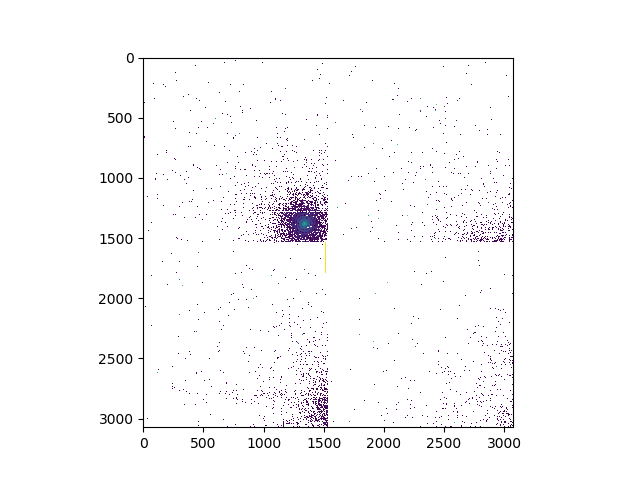

In [7]:
data = h5py.File(data_path, 'r')['entry/data/data'][()][0, 0, :, :]
print(np.max(data),np.min(data))
plt.figure()
plt.imshow(np.log(data))
np.save('difpad.npy',data)

-- Calling MPI code to read /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho2d/SS61/scans/0000_SS61_001.hdf5
0 0


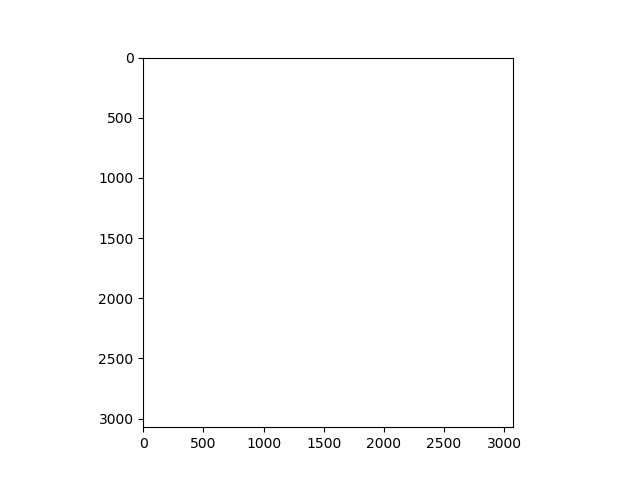

In [6]:
data2,_ = io.read_volume(data_path, 'numpy', use_MPI=True, nprocs=n_of_threads)
print(np.max(data2),np.min(data2))
plt.figure()
plt.imshow(np.log(data2[0]))

In [3]:
# deploy_frame_viewer(processed_data)